In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 그래프 설정
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 경고 메시지 억제
import warnings
warnings.filterwarnings('ignore')  

In [2]:
# 데이터 로드 및 ID 제거
df = pd.read_csv('final_features.csv')
df.drop('ID', axis = 1, inplace = True)
X = df.copy()
y = X.pop('Segment')

# E vs not-E 이진 타깃 생성
y_e = (y == 'E').astype(int)

# 학습/검증 분할 (20% 검증, E 분포 유지)
X_train, X_val, y_train_e, y_val_e, y_train, y_val = train_test_split(
    X, y_e, y, test_size=0.25, random_state=42, stratify=y_e
)

In [3]:
# 1. 모델1: E vs not-E 분류
model1 = LGBMClassifier(verbose=-1, random_state = 42)

# E vs not-E
model1.fit(X_train, y_train_e)

# 검증셋 E vs not-E
y1_pred = model1.predict(X_val)

print("=== 모델1: E vs not-E ===")
print(confusion_matrix(y_val_e, y1_pred))
print(classification_report(y_val_e, y1_pred, target_names=['not-E','E']))

# 검증셋 DataFrame 및 pred1 추가
df_val = pd.DataFrame(X_val, columns=X.columns)
df_val['true_seg'] = y_val.values
df_val['pred1']    = y1_pred

=== 모델1: E vs not-E ===
[[13533  6382]
 [ 3327 76758]]
              precision    recall  f1-score   support

       not-E       0.80      0.68      0.74     19915
           E       0.92      0.96      0.94     80085

    accuracy                           0.90    100000
   macro avg       0.86      0.82      0.84    100000
weighted avg       0.90      0.90      0.90    100000



In [4]:
# pred1 == 0 (not-E) 데이터
df_val_notE = df_val[df_val['pred1'] == 0].reset_index(drop=True)
X_val_notE  = df_val_notE[X.columns]

# A/B vs C/D 레이블 (A,B→1 / C,D→0)
y2_true = df_val_notE['true_seg'].apply(lambda s: 1 if s in ['A','B'] else 0)

# 학습셋 not-E 샘플 및 A/B vs C/D 타깃
mask_train_notE = (y_train_e == 0)
X_train_notE    = X_train[mask_train_notE]
y_train_notE    = y_train[mask_train_notE].apply(lambda s: 1 if s in ['A','B'] else 0)

# XGBoost 분류기 
model2 = LGBMClassifier(random_state=42, verbose=-1)

# A/B vs C/D
model2.fit(X_train_notE, y_train_notE)

# 검증셋 A/B vs C/D
y2_pred = model2.predict(X_val_notE)

print("\n=== 모델2: A/B vs C/D ===")
print(confusion_matrix(y2_true, y2_pred))
print(classification_report(y2_true, y2_pred, target_names=['C/D','A/B']))

# pred2 컬럼
df_val_notE['pred2'] = y2_pred


=== 모델2: A/B vs C/D ===
[[16768    46]
 [   37     9]]
              precision    recall  f1-score   support

         C/D       1.00      1.00      1.00     16814
         A/B       0.16      0.20      0.18        46

    accuracy                           1.00     16860
   macro avg       0.58      0.60      0.59     16860
weighted avg       1.00      1.00      1.00     16860



#### 모델2가 “A/B”로 예측한 6개 샘플에 대해서만 모델3을 돌려본 것

In [5]:
# 모델3: A vs B 분류
# pred2 == 1 (A/B로 예측된) 데이터
df_val_AB = df_val_notE[df_val_notE['pred2'] == 1].reset_index(drop=True)
X_val_AB  = df_val_AB[X.columns]

# A vs B 레이블 (B→1 / A→0)
y3_true = df_val_AB['true_seg'].apply(lambda s: 1 if s == 'B' else 0)

# 학습셋 A/B 샘플 및 A vs B 타깃
mask_train_AB = mask_train_notE & (y_train.isin(['A','B']))
X_train_AB    = X_train[mask_train_AB]
y_train_AB    = y_train[mask_train_AB].apply(lambda s: 1 if s == 'B' else 0)

# XGBoost 분류기 
model3 = LGBMClassifier(random_state=42, verbose=-1)

# A vs B
model3.fit(X_train_AB, y_train_AB)

# 검증셋 A vs B
y3_pred = model3.predict(X_val_AB)

print("\n=== 모델3: A vs B ===")
print(confusion_matrix(y3_true, y3_pred))
print(classification_report(y3_true, y3_pred, labels=[0,1], target_names=['A','B']))


=== 모델3: A vs B ===
[[53  2]
 [ 0  0]]
              precision    recall  f1-score   support

           A       1.00      0.96      0.98        55
           B       0.00      0.00      0.00         0

    accuracy                           0.96        55
   macro avg       0.50      0.48      0.49        55
weighted avg       1.00      0.96      0.98        55



#### 진짜 A/B인 37개 샘플에 대해서만 모델3을 돌려본 것

In [6]:
# 실제 A/B 전체를 추출
df_val_trueAB = df_val_notE[df_val_notE['true_seg'].isin(['A','B'])]

X_val_trueAB = df_val_trueAB[X.columns]
y3_true_all  = df_val_trueAB['true_seg'].apply(lambda s: 1 if s == 'B' else 0)

# model3에 전체 A/B 데이터로 평가
y3_pred_all = model3.predict(X_val_trueAB)

print(confusion_matrix(y3_true_all, y3_pred_all))
print(classification_report(y3_true_all, y3_pred_all, labels=[0,1], target_names=['A','B']))

[[39  0]
 [ 6  1]]
              precision    recall  f1-score   support

           A       0.87      1.00      0.93        39
           B       1.00      0.14      0.25         7

    accuracy                           0.87        46
   macro avg       0.93      0.57      0.59        46
weighted avg       0.89      0.87      0.83        46



#### 모델2가 “C/D”로 예측한 6개 샘플에 대해서만 모델4를 돌려본 것

In [7]:
# 4. 모델4: C vs D 분류
# pred2 == 0 (C/D로 예측된) 데이터
df_val_CD = df_val_notE[df_val_notE['pred2'] == 0].reset_index(drop=True)
X_val_CD  = df_val_CD[X.columns]

# C vs D 레이블 (D→1 / C→0)
y4_true = df_val_CD['true_seg'].apply(lambda s: 1 if s == 'D' else 0)

# 학습셋 C/D 샘플 및 C vs D 타깃
mask_train_CD = mask_train_notE & (y_train.isin(['C','D']))
X_train_CD    = X_train[mask_train_CD]
y_train_CD    = y_train[mask_train_CD].apply(lambda s: 1 if s == 'D' else 0)

# XGBoost 분류기 
model4 = LGBMClassifier(random_state=42, verbose=-1)

# C vs D
model4.fit(X_train_CD, y_train_CD)

# 검증셋 C vs D
y4_pred = model4.predict(X_val_CD)

print("\n=== 모델4: C vs D ===")
print(confusion_matrix(y4_true, y4_pred))
print(classification_report(y4_true, y4_pred, target_names=['C','D']))


=== 모델4: C vs D ===
[[2840 5091]
 [ 887 7987]]
              precision    recall  f1-score   support

           C       0.76      0.36      0.49      7931
           D       0.61      0.90      0.73      8874

    accuracy                           0.64     16805
   macro avg       0.69      0.63      0.61     16805
weighted avg       0.68      0.64      0.61     16805



#### 진짜 C/D 인 샘플에 대해서만 모델4를 돌려본 것

In [8]:
# 실제 C/D 레이블인 모든 검증셋 샘플
df_val_trueCD = df_val_notE[df_val_notE['true_seg'].isin(['C','D'])].reset_index(drop=True)
X_val_trueCD  = df_val_trueCD[X.columns]

# C vs D 레이블 (D→1 / C→0)
y4_true_all   = df_val_trueCD['true_seg'].apply(lambda s: 1 if s == 'D' else 0)

# model4로 전체 C/D 샘플 예측
y4_pred_all   = model4.predict(X_val_trueCD)

# 결과 출력
print("=== 모델4 standalone: 실제 C/D 전체 평가 ===")
print(confusion_matrix(y4_true_all, y4_pred_all))
print(classification_report(y4_true_all, y4_pred_all, labels=[0,1], target_names=['C','D']))

=== 모델4 standalone: 실제 C/D 전체 평가 ===
[[2614 1995]
 [ 891 7987]]
              precision    recall  f1-score   support

           C       0.75      0.57      0.64      4609
           D       0.80      0.90      0.85      8878

    accuracy                           0.79     13487
   macro avg       0.77      0.73      0.75     13487
weighted avg       0.78      0.79      0.78     13487



=== ✅ 최종 모델 통합 성능 평가 (A/B/C/D/E) ===
              precision    recall  f1-score   support

           A       0.17      0.23      0.20        39
           B       0.00      0.00      0.00         7
           C       0.69      0.48      0.57      5336
           D       0.61      0.55      0.58     14533
           E       0.92      0.96      0.94     80085

    accuracy                           0.87    100000
   macro avg       0.48      0.44      0.46    100000
weighted avg       0.87      0.87      0.87    100000



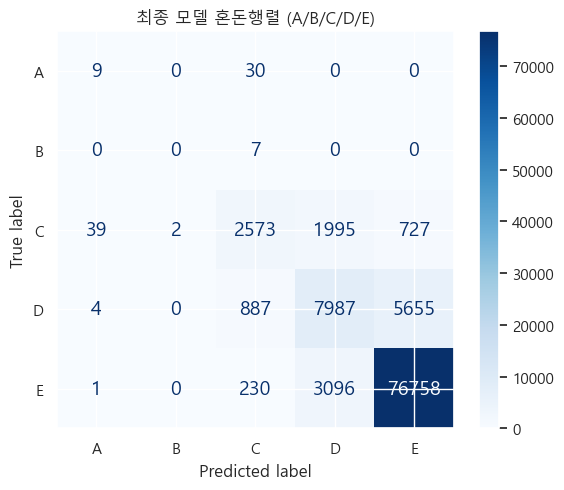

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 최종 예측된 세그먼트 구성

# 1. E로 예측된 고객
df_pred_E = df_val[df_val['pred1'] == 1].copy()
df_pred_E['final_pred'] = 'E'

# 2. A/B로 예측된 고객
df_pred_AB = df_val_notE[df_val_notE['pred2'] == 1].copy()
df_pred_AB['final_pred'] = np.where(y3_pred == 1, 'B', 'A')

# 3. C/D로 예측된 고객
df_pred_CD = df_val_notE[df_val_notE['pred2'] == 0].copy()
df_pred_CD['final_pred'] = np.where(y4_pred == 1, 'D', 'C')

# 4. 통합
df_val_all = pd.concat([df_pred_E, df_pred_AB, df_pred_CD], axis=0).reset_index(drop=True)

# 평가
y_true_final = df_val_all['true_seg']
y_pred_final = df_val_all['final_pred']

print("=== ✅ 최종 모델 통합 성능 평가 (A/B/C/D/E) ===")
print(classification_report(y_true_final, y_pred_final, labels=['A','B','C','D','E']))

# 혼돈행렬 출력
labels = ['A', 'B', 'C', 'D', 'E']
cm = confusion_matrix(y_true_final, y_pred_final, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("최종 모델 혼돈행렬 (A/B/C/D/E)")
plt.tight_layout()
plt.show()